In [1]:
import numpy as np
from PIL import Image
from skimage import draw
import random
from pathlib import Path

def create_image(path, img_size, min_radius):
    path.parent.mkdir( parents=True, exist_ok=True )
    
    arr = np.zeros((img_size, img_size)).astype(np.uint8)
    center_x = random.randint(min_radius, (img_size-min_radius))
    center_y = random.randint(min_radius, (img_size-min_radius))
    max_radius = min(center_x, center_y, img_size - center_x, img_size - center_y)
    radius = random.randint(min_radius, max_radius)

    row_indxs, column_idxs = draw.ellipse(center_x, center_y, radius, radius, shape=arr.shape)
    
    arr[row_indxs, column_idxs] = 255

    im = Image.fromarray(arr)
    im.save(path)

def create_images(data_root_path, train_num, val_num, test_num, img_size=640, min_radius=10):
    data_root_path = Path(data_root_path)
    
    for i in range(train_num):
        create_image(data_root_path / 'train' / 'images' / f'img_{i}.png', img_size, min_radius)
        
    for i in range(val_num):
        create_image(data_root_path / 'val' / 'images' / f'img_{i}.png', img_size, min_radius)
        
    for i in range(test_num):
        create_image(data_root_path / 'test' / 'images' / f'img_{i}.png', img_size, min_radius)

create_images('datasets', train_num=120, val_num=40, test_num=40, img_size=120, min_radius=10)

In [2]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 15.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from rasterio import features

def create_label(image_path, label_path):
    arr = np.asarray(Image.open(image_path))

    # There may be a better way to do it, but this is what I have found so far
    cords = list(features.shapes(arr, mask=(arr >0)))[0][0]['coordinates'][0]
    label_line = '0 ' + ' '.join([f'{int(cord[0])/arr.shape[0]} {int(cord[1])/arr.shape[1]}' for cord in cords])

    label_path.parent.mkdir( parents=True, exist_ok=True )
    with label_path.open('w') as f:
        f.write(label_line)

for images_dir_path in [Path(f'datasets/{x}/images') for x in ['train', 'val', 'test']]:
    for img_path in images_dir_path.iterdir():
        label_path = img_path.parent.parent / 'labels' / f'{img_path.stem}.txt'
        label_line = create_label(img_path, label_path)

In [4]:
yaml_content = f'''
train: train/images
val: val/images
test: test/images

names: ['circle']
    '''
    
with Path('data.yaml').open('w') as f:
    f.write(yaml_content)

In [5]:
pip install ultralytics==8.0.38


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 3.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 56.8 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.1.9
    Uninstalling ultralytics-8.1.9:
      Successfully uninstalled ultralytics-8.1.9
Note: you may need to restart the kernel to use updated packages.


In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

results = model.train(
        batch=8,
        device="cpu",
        data="data.yaml",
        epochs=7,
        imgsz=120,
    )

WARNING ⚠️ Ultralytics settings reset to defaults. This is normal and may be due to a recent ultralytics package update, but may have overwritten previous settings. 
View and update settings with 'yolo settings' or at '/users/dmoi/.config/Ultralytics/settings.yaml'


  0%|          | 0.00/6.73M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.38 🚀 Python-3.10.8 torch-1.13.1 CPU
yolo/engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=data.yaml, epochs=7, patience=50, batch=8, imgsz=120, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False

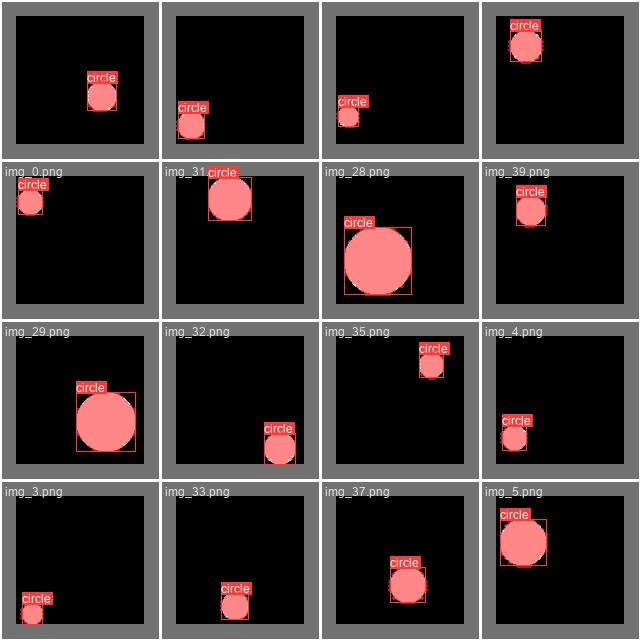

In [8]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train/val_batch0_labels.jpg")